<a target="_blank" href="https://colab.research.google.com/github/Blaizzy/Coding-LLMs-from-scratch/blob/main/Llama-2/Part 2/BabyLLaMA.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

 # BabyLLaMA

Coding the LLaMA-2 research paper from scratch to create models with sizes 100M, 250M and 500M params.

## Model Arch

Decoder only: Composed of identical `n_layers`. Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple position-wise fully connected FFN. We employ residual connection around each of the sub-layers, followed by layers normalizatin. That is:
LayerNorm(x + Sublayer(x))
 -- A Vaswani et al., 2017.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from math import sqrt

In [ ]:
n_layers = 6 # 22 Tiny LLaMA
n_heads = 6 # 32 Tiny LLaMA
d_model = 768 # 2048 Tiny LLaMA
intermediate_dim = d_model * 4

### MHA
<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" width=500>

In [ ]:
# Generate random input data
sequence_length = 10 # number of tokens
batch_size = 5
input_data = torch.rand((batch_size, sequence_length, d_model)) # [bs, sequence_length, d_model]

In [ ]:
input_data.shape

torch.Size([5, 10, 768])

- MQA
- GQA

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super(AttentionHead, self).__init__()
        self.q = nn.Linear(embed_dim, hidden_dim)
        self.k = nn.Linear(embed_dim, hidden_dim)
        self.v = nn.Linear(embed_dim, hidden_dim)

    def scaled_dot_product_attention(self, q, k, v, mask = None):
        dim_k = q.size(-1)
        scores = torch.bmm(q, k.transpose(1, 2)) / sqrt(dim_k) # k.T = [bs, seq_len, embed_dim] -> [bs, embed_dim, seq_len]
        if mask is not None:
            scores = torch.masked_fill(scores, mask == 0, -torch.inf)
        weights = F.softmax(scores, dim=-1)
        return torch.bmm(weights, v)

    def forward(self, hidden_state, mask = None):
        output = self.scaled_dot_product_attention(
            self.q(hidden_state), self.k(hidden_state), self.v(hidden_state), mask=mask
        )
        return output

In [ ]:
attn = AttentionHead(d_model, d_model//n_heads)
attn(input_data).shape

torch.Size([5, 10, 128])

## MHA vs GQA vs MQA
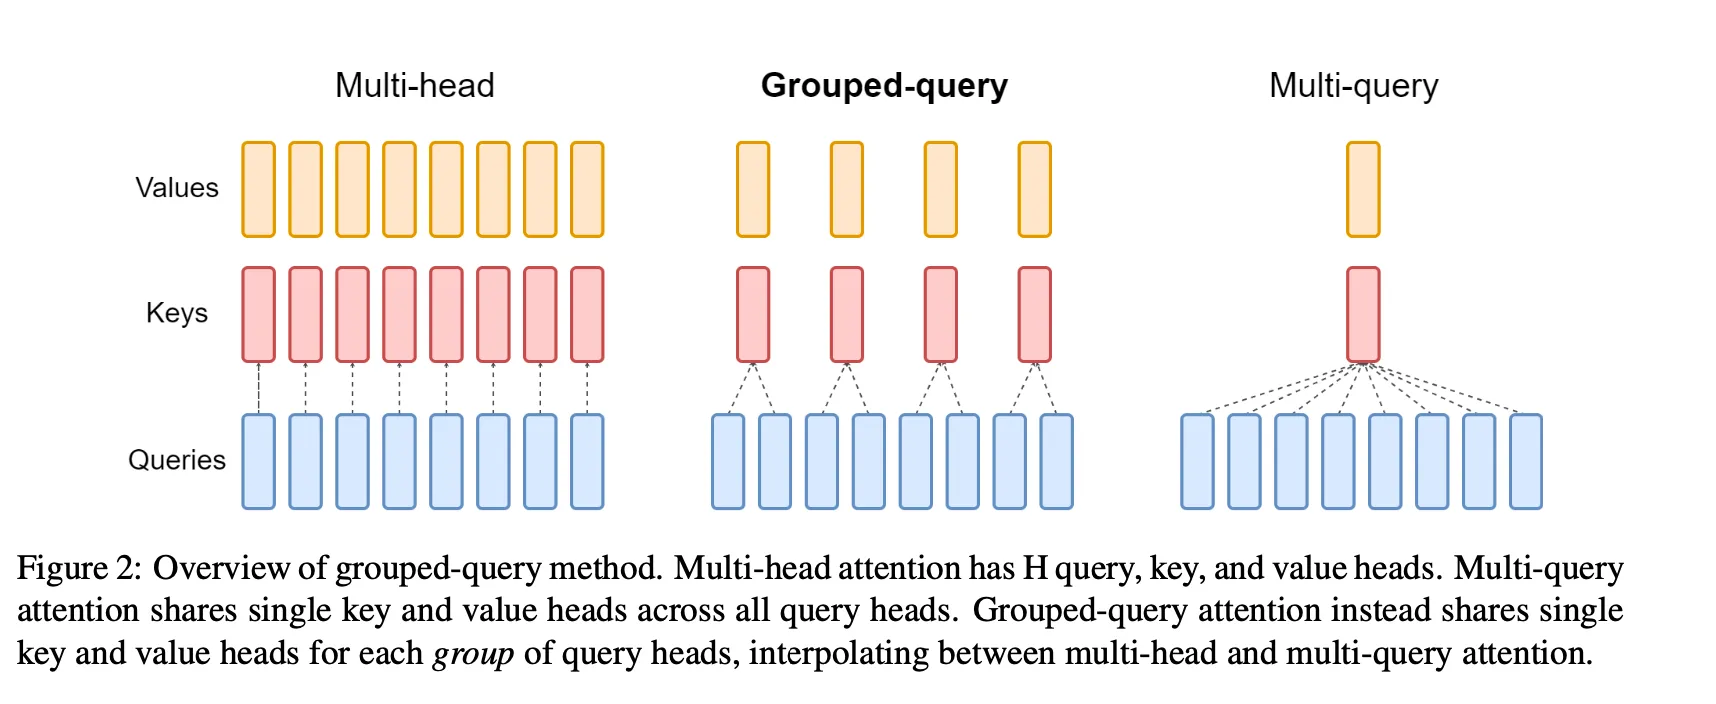

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, hidden_dim):
        super(MultiHeadAttention, self).__init__()
        embed_dim = hidden_dim
        head_dim = hidden_dim // n_heads
        self.heads =  nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(n_heads)]
        )
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1)
        return self.out_proj(x)


class MultiQueryAttention(nn.Module):
    def __init__(self, n_q_heads, hidden_dim):
        super(MultiQueryAttention, self).__init__()
        head_dim = hidden_dim // n_heads
        self.queries = nn.ModuleList(
            [nn.Linear(hidden_dim, head_dim) for _ in range(n_q_heads)]
        )
        self.key = nn.Linear(hidden_dim, head_dim)
        self.value = nn.Linear(hidden_dim, head_dim)
        self.out_proj = nn.Linear(n_q_heads * head_dim, hidden_dim)

    def scaled_dot_product_attention(self, q, k, v, mask = None):
        dim_k = q.size(-1)
        scores = torch.bmm(q, k.transpose(1, 2)) / sqrt(dim_k) # k.T = [bs, seq_len, embed_dim] -> [bs, embed_dim, seq_len]
        if mask is not None:
            scores = torch.masked_fill(scores, mask == 0, -torch.inf)
        weights = F.softmax(scores, dim=-1)
        return torch.bmm(weights, v)

    def forward(self, hidden_state):
        k = self.key(hidden_state)
        v = self.value(hidden_state)
        x = torch.cat([
            self.scaled_dot_product_attention(query(hidden_state), k, v)
            for query in self.queries
        ], dim=-1)
        return self.out_proj(x)


class GroupedQueryAttention(nn.Module):
    def __init__(self, n_q_heads_per_group, n_k_v_heads, hidden_dim):
        super(GroupedQueryAttention, self).__init__()
        self.n_k_v_heads = n_k_v_heads
        self.n_q_heads_per_group = n_q_heads_per_group
        self.hidden_dim = hidden_dim
        self.grouped = nn.ModuleList([
            MultiQueryAttention(
                n_q_heads=n_q_heads_per_group, hidden_dim=hidden_dim
            )
            for _ in range(n_k_v_heads)
        ])
        self.proj = nn.Linear(in_features=hidden_dim * n_k_v_heads,
                              out_features=hidden_dim, bias=False)

    def forward(self, hidden_state, mask=None):
        Z_s = torch.cat([head(hidden_state) for head in self.grouped], dim=-1)
        Z = self.proj(Z_s)
        return Z

In [ ]:
mha = MultiHeadAttention(n_heads, d_model)
mha(input_data).shape

torch.Size([5, 10, 768])

In [ ]:
count_parameters(mha)

2362368

In [ ]:
mqa = MultiQueryAttention(n_heads, d_model)
mqa(input_data).shape

torch.Size([5, 10, 768])

In [ ]:
count_parameters(mqa)

1378048

In [ ]:
num_q_heads = n_heads
n_k_v_heads=2
n_q_heads_per_group = num_q_heads // n_k_v_heads

gqa = GroupedQueryAttention(n_q_heads_per_group=n_q_heads_per_group, n_k_v_heads=n_k_v_heads, hidden_dim=d_model)
gqa(input_data).shape

torch.Size([5, 10, 768])

In [ ]:
count_parameters(gqa)

2755328

In [ ]:
mha

MHA(
  (heads): ModuleList(
    (0-5): 6 x AttentionHead(
      (q): Linear(in_features=768, out_features=128, bias=True)
      (k): Linear(in_features=768, out_features=128, bias=True)
      (v): Linear(in_features=768, out_features=128, bias=True)
    )
  )
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
)

In [ ]:
class LLaMAMLP(nn.Module):
    def __init__(self, hidden_dim, intermediate_dim): # in MLP: intermediate_dim= 4 * hidden_dim
        super(LLaMAMLP, self).__init__()
        self.linear_1 = nn.Linear(hidden_dim, intermediate_dim)
        self.linear_2 = nn.Linear(hidden_dim, intermediate_dim) # Original: intermediate -> hidden.
        self.activation_fn = nn.SiLU()
        self.out_proj = nn.Linear(intermediate_dim, hidden_dim) # Original: dropout


    def forward(self, hidden_state):
        x_fc_1 = self.linear_1(hidden_state)
        x_fc_2 = self.linear_2(hidden_state)
        x = self.activation_fn(x_fc_1) * x_fc_2
        return self.out_proj(x)

In [ ]:
mlp = LLaMAMLP(d_model, intermediate_dim)
mlp(input_data).shape

torch.Size([5, 10, 768])

In [ ]:
class Block(nn.Module):
    def __init__(self, n_heads, n_k_v_heads, hidden_dim, intermediate_dim):
        super(Block, self).__init__()
        self.n_heads = n_heads
        self.hidden_dim = hidden_dim
        self.intermediate_dim = intermediate_dim

        # Self-Attention (MHA, MQA & GQA)
        if n_heads == n_k_v_heads:
            # MHA selected
            self.attn = MultiHeadAttention(n_heads,  hidden_dim=hidden_dim)
        elif n_k_v_heads == 1 :
            # MQA selected
            self.attn = MultiQueryAttention(n_heads, hidden_dim=hidden_dim)
        elif n_heads // n_k_v_heads > 1:
            # GQA selected
            self.attn = GroupedQueryAttention(n_heads // n_k_v_heads, n_k_v_heads,  hidden_dim=hidden_dim)
        else:
            # MHA selected
            self.attn = MultiHeadAttention(n_heads, hidden_dim=hidden_dim)

        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.mlp = LLaMAMLP(hidden_dim, intermediate_dim)

    def forward(self, hidden_state, mask=None):
        x = self.attn(hidden_state)
        x = self.layer_norm(hidden_state) + x
        x_fc = self.mlp(x)
        x += x_fc
        return x


In [ ]:
block = Block(n_heads, n_k_v_heads, d_model, intermediate_dim)
block(input_data).shape

GQA selected


torch.Size([5, 10, 768])

In [ ]:
class babyLLaMA(nn.Module):
    def __init__(self, max_seq_len, vocab_size, n_layers, n_heads, n_k_v_heads, hidden_dim, intermediate_dim):
        super(babyLLaMA, self).__init__()
        self.emb = nn.Embedding(vocab_size, hidden_dim)
        self.pos = nn.Embedding(max_seq_len, hidden_dim)
        self.blocks = nn.ModuleList(
            [Block(n_heads, n_k_v_heads, hidden_dim, intermediate_dim) for _ in range(n_layers)]
        )
        self.out_proj = nn.Linear(hidden_dim, vocab_size)

    def forward(self, hidden_state):
        emb = self.emb(hidden_state)
        seq_len = hidden_state.size(1)
        positions = torch.arange(seq_len, dtype=torch.long).unsqueeze(0)
        pos = self.pos(positions)
        x = emb + pos

        for b in self.blocks:
            x = b(x)

        x = self.out_proj(x)
        return F.softmax(x, dim=-1)


In [ ]:
llm = babyLLaMA(d_model, 32000, 22, n_heads, n_k_v_heads, d_model, intermediate_dim)
input_ids = torch.randint(1, 32000, (batch_size, sequence_length))

In [ ]:
llm(input_ids).shape

torch.Size([5, 10, 32000])

In [ ]:
llm

babyLLaMA(
  (emb): Embedding(32000, 768)
  (pos): Embedding(768, 768)
  (blocks): ModuleList(
    (0-21): 22 x Block(
      (mqa): MultiQueryAttention(
        (queries): ModuleList(
          (0-5): 6 x Linear(in_features=768, out_features=128, bias=True)
        )
        (key): Linear(in_features=768, out_features=128, bias=True)
        (value): Linear(in_features=768, out_features=128, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): LLaMAMLP(
        (linear_1): Linear(in_features=768, out_features=3072, bias=True)
        (linear_2): Linear(in_features=768, out_features=3072, bias=True)
        (activation_fn): SiLU()
        (out_proj): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (out_proj): Linear(in_features=768, out_features=32000, bias=True)
)

In [ ]:
count_parameters(llm)

266290432